<a href="https://colab.research.google.com/github/reyksayk/Comparaci-n-de-las-diferentes-t-cnica-y-modelos-de-Procesamiento-de-Lenguaje-Natural-/blob/main/Modelos/%20Usuarios/%20Ansiedad%20/LDA%20y%20Word2Vec/%20Red%20Neuronal%2C%20Bosque%20aleatorio%2C%20SVM%2C%20Regresi%C3%B3n%20log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

# datos

**usarios con Ansiedad** = 1
**usarios con Control** = 0

**PREPARACIÓN DE DATOS**

*Cargar y limpiar*

In [ ]:
!pip install pyspellchecker
!pip install spacy
!python -m spacy download es_core_news_sm

# limpiar texto y Crear Tokens

In [ ]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter='\t')  # Indicamos el delimitador como '\t' para TSV
        return data
    except Exception as e:
        print("Error:", e)
        return None

#Creamos un función de limpieza del texto y  los guarde en tokens indivicuales o lista de palabras
def clean_doc(text):
    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)

    # Eliminar URLs o enlaces
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

    # Eliminar nombres de usuarios de Twitter
    text = re.sub(r'@\w+', '', text)

    # Eliminar Nombres propios
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

    # Eliminar todos los caracteres especiales
    text = re.sub(r'[^\w\s]+', '', text)

    # Eliminar prefijos y números
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

    # Eliminar palabras específicas
    specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                      'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                      'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                      'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                      'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                      'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                      'it','we','they','the','and','that','these','those','tweet','followed','follower']
    text = ' '.join([word for word in text.split() if word not in specific_words])

    # Eliminar emojis
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                 '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                 ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')

    # Convertir el texto a minúsculas
    text = text.lower()

    return text


In [ ]:
def process_docs(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            text = clean_doc(text)
            texts.append(text.split())  # Dividir el texto en palabras
    return texts

In [ ]:
# Cargar y preprocesar documentos
Ans = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/')
Cont = process_docs('/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/')

In [ ]:
# Concatenar listas de textos
all_texts = Ans + Cont

# Entrenar el modelo Word2Vec
modelW = Word2Vec(sentences=all_texts, vector_size=300, window=5, min_count=1, sg=0)


In [ ]:
def document_vector(tokens, modelW):
    # Filtrar palabras que no están en el modelo
    tokens = [token for token in tokens if token in modelW.wv.key_to_index]
    if len(tokens) == 0:
        return np.zeros(modelW.vector_size)
    return np.mean([modelW.wv[token] for token in tokens], axis=0)


In [ ]:
# Vectorizar los documentos usando la función document_vector
X = np.array([document_vector(doc, modelW) for doc in all_texts])
X[X < 0] = 0

In [ ]:
X.shape

(180, 300)

In [ ]:
print(modelW)
print(len(modelW.wv))
# Observamos el vocabulario creado
words = modelW.wv.index_to_key
print(words)

In [ ]:
# Obtener la representación vectorial de una palabra específica
vector = modelW.wv['ansiedad', 'depresión']
vector

array([[ 4.26847368e-01,  1.71993464e-01,  3.45825046e-01,
         4.61315185e-01, -2.50795335e-01, -6.12816513e-01,
         7.34516442e-01,  8.00053418e-01, -3.51320915e-02,
         1.87686577e-01,  6.11595437e-02, -2.25251004e-01,
        -1.66458398e-01,  4.98404443e-01, -5.66716027e-03,
        -3.17374796e-01,  2.44957253e-01,  3.80374968e-01,
        -1.11728996e-01, -2.02512845e-01, -2.80324835e-02,
        -1.28250360e-01,  4.82434928e-01,  2.60166705e-01,
         3.52267385e-01,  5.82203269e-02, -7.51896679e-01,
        -3.10259253e-01, -6.71485245e-01, -1.54739782e-01,
         3.55570763e-01,  5.24768084e-02, -7.48770460e-02,
         2.16762036e-01, -4.32461143e-01,  2.11014733e-01,
         3.63365561e-02, -6.62179410e-01, -3.14125717e-01,
        -7.53904402e-01, -5.85418880e-01,  1.77731082e-01,
        -1.50777057e-01, -3.50244403e-01,  4.80277210e-01,
         1.39122999e+00, -1.64011300e-01, -1.55780569e-01,
        -1.83682323e-01,  6.19540811e-01,  2.56963849e-0

In [ ]:
# Crear etiquetas para los datos
Y = np.array([1] * len(Ans) + [0] * len(Cont))



# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# Verificar las dimensiones después de la división
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_val:", y_val.shape)


Dimensiones de X_train: (126, 300)
Dimensiones de y_train: (126,)
Dimensiones de X_val: (54, 300)
Dimensiones de y_val: (54,)


#Redución de dimensionalidad con LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Aplicar LDA para reducir la dimensionalidad
n_topics = 70  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train = lda.fit_transform(X_train, y_train)
X_val = lda.transform(X_val)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(126, 70)
(54, 70)
(126,)
(54,)


**Modelo análisis de texto**

#Red neuronal

In [ ]:
# Crear una red neuronal secuencial

model = Sequential()

# Agregar una capa de entrada con el número de características
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/100
3/3 [==============================] - 2s 110ms/step - loss: 0.6934 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.4630
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6937 - accuracy: 0.4841 - val_loss: 0.6929 - val_accuracy: 0.5370
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 0.6927 - accuracy: 0.5159 - val_loss: 0.6941 - val_accuracy: 0.4630
Epoch 4/100
3/3 [==============================] - 0s 16ms/step - loss: 0.6925 - accuracy: 0.5317 - val_loss: 0.6969 - val_accuracy: 0.4630
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6924 - accuracy: 0.5159 - val_loss: 0.6991 - val_accuracy: 0.4630
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.6921 - accuracy: 0.5159 - val_loss: 0.6991 - val_accuracy: 0.4630
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 0.6934 - accuracy: 0.5159 - val_loss: 0.6985 - val_accuracy: 0.4630
Epoch 8/100
3/3 [==

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 52.0%
Precisión (entrenamiento): 52.0%
Recall (entrenamiento): 100.0%
F1-score (entrenamiento): 68.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 46.0%
Precisión en el conjunto de validación: 46.0%
Recall en el conjunto de validación: 100.0%
F1-score en el conjunto de validación: 63.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

2/2 [==============================] - 0s 4ms/step
Matriz de confusión: 

 [[ 0 29]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 1.00


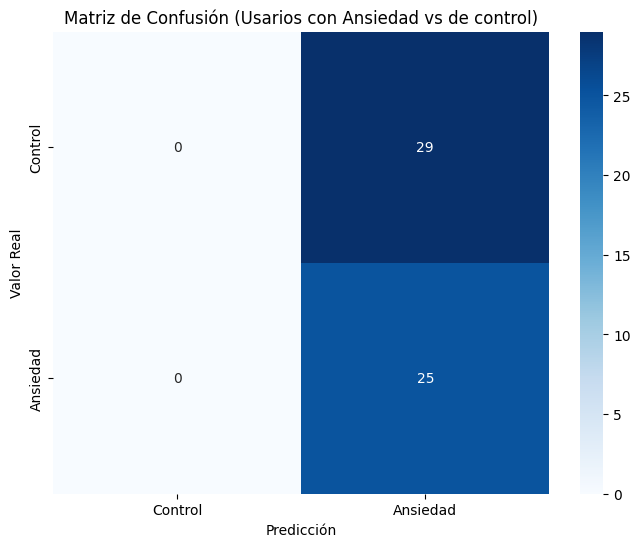

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Bosque Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split


# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.59
Precision (validación): 0.55
Recall (validación): 0.68
F1-score (validación): 0.61


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 100.00%
Precisión  entrenamiento: 100.00%
Recall  entrenamiento: 100.00%
Puntuación F1  entrenamiento: 100.00%


Accuracy  validación: 59.26%
Precisión  validación: 54.84%
Recall  validación: 68.00%
Puntuación F1 validación: 60.71%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[15 14]
 [ 8 17]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.57


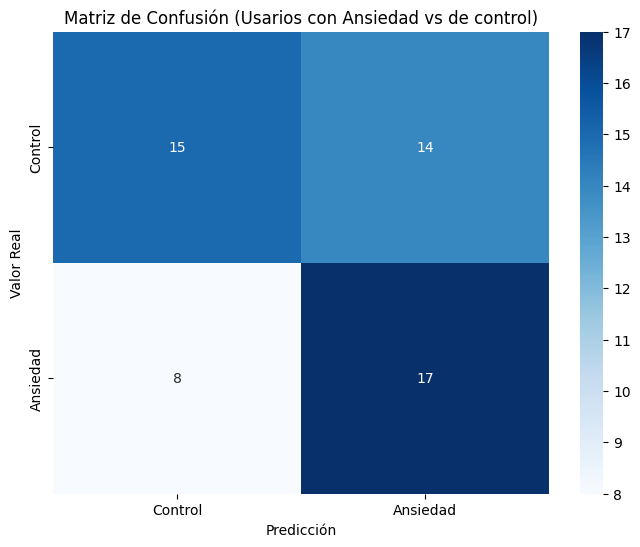

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='linear', degree=4, C=10000,  gamma='scale', coef0=2.5)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")




Entrenamiento:
Exactitud (entrenamiento): 75.40%
Precision (entrenamiento): 69.77%
Recall (entrenamiento): 92.31%
F1-score (entrenamiento): 79.47%

Validación:
Exactitud en el conjunto de validación: 56.00000000000001%
Precisión en el conjunto de validación:51.0%
Recall en el conjunto de validación: 80.0%
F1-score en el conjunto de validación:62.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[10 19]
 [ 5 20]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 0.72


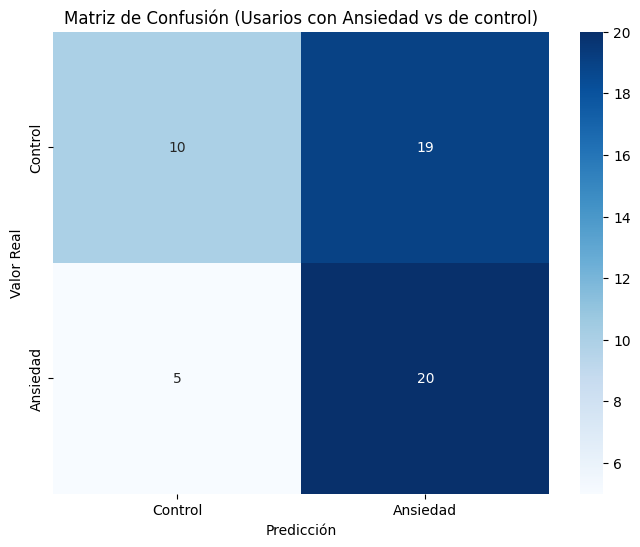

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=100)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 53.17%
Precisión (entrenamiento): 52.42%
Exhaustividad (entrenamiento): 100.00%
Puntuación F1 (entrenamiento): 68.78%
----------------------------------------

Métricas de validación:
Exactitud (validación): 46.30%
Precisión (validación): 46.30%
Exhaustividad (validación): 100.00%
Puntuación F1 (validación): 63.29%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[ 0 29]
 [ 0 25]] 

Proporción de comentarios positivos: 0.46
Proporción de comentarios positivos etiquetados: 1.00


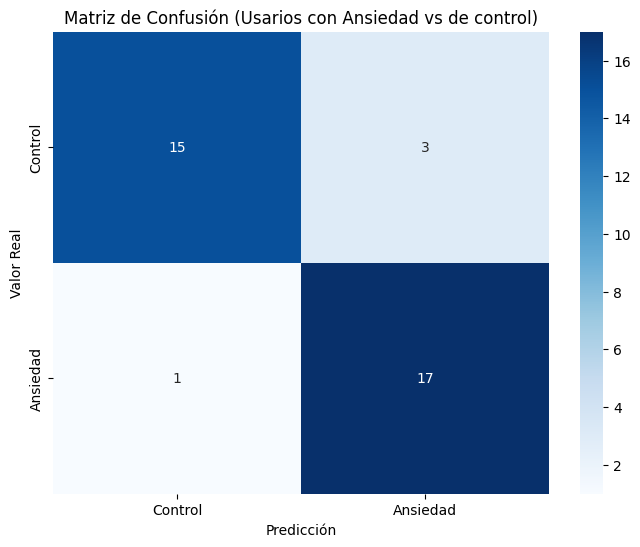

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()